In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend as K
from keras.preprocessing import image

Using TensorFlow backend.


## 이미지 가져오기 

In [2]:
import glob
image_list = glob.glob("얼굴사진정제/*.jpg")

In [3]:
print(len(image_list))

1995


# Generating images

This notebook contains the second code sample found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


## Variational autoencoders


Variational autoencoders, simultaneously discovered by Kingma & Welling in December 2013, and Rezende, Mohamed & Wierstra in January 2014, 
are a kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on 
autoencoders -- a type of network that aims to "encode" an input to a low-dimensional latent space then "decode" it back -- that mixes ideas 
from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an "encoder" module, then decode it back to an output 
with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the _same images_ as the 
input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. 
the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most 
commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way 
to compress the input data into fewer bits of information.

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)


In practice, such classical autoencoders don't lead to particularly useful or well-structured latent spaces. They're not particularly good 
at compression, either. For these reasons, they have largely fallen out of fashion over the past years. Variational autoencoders, however, 
augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They 
have turned out to be a very powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed "code" in the latent space, turns the image into the parameters of a statistical 
distribution: a mean and a variance. Essentially, this means that we are assuming that the input image has been generated by a statistical 
process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean 
and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The 
stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every 
point sampled in the latent will be decoded to a valid output.

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)


In technical terms, here is how a variational autoencoder works. First, an encoder module turns the input samples `input_img` into two 
parameters in a latent space of representations, which we will note `z_mean` and `z_log_variance`. Then, we randomly sample a point `z` 
from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where 
epsilon is a random tensor of small values. Finally, a decoder module will map this point in the latent space back to the original input 
image. Because `epsilon` is random, the process ensures that every point that is close to the latent location where we encoded `input_img` 
(`z-mean`) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close 
points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, 
forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured 
and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: first, a reconstruction loss that forces the decoded samples to match the 
initial inputs, and a regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's quickly go over a Keras implementation of a VAE. Schematically, it looks like this:

Here is the encoder network we will use: a very simple convnet which maps the input image `x` to two vectors, `z_mean` and `z_log_variance`.

In [4]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (128, 128, 3)
batch_size = 64
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape, dtype = 'float32')

In [5]:
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

encoder = Model(input_img,[z_mean,z_log_var])

In [6]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

In [7]:
class Sampling(layers.Layer):
    def __init__(self):
        super(Sampling, self).__init__()
    
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=(K.shape(mean)[0], latent_dim), mean=0., stddev=1.)
        return mean + K.exp(log_var) * epsilon


z = Sampling()([z_mean, z_log_var])

In [8]:
z_mean,K.shape(z_mean)[0], z, shape_before_flattening

(<tf.Tensor 'dense_1/Identity:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'strided_slice:0' shape=() dtype=int32>,
 <tf.Tensor 'sampling/Identity:0' shape=(None, 2) dtype=float32>,
 (None, 64, 64, 64))


This is the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.

In [9]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

In [10]:
decoder_input, z

(<tf.Tensor 'input_2:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'sampling/Identity:0' shape=(None, 2) dtype=float32>)

In [11]:
# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
z_decoded = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, z_decoded)

# variational autoencoder model
vae = Model(input_img, decoder(z))

In [12]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 262144)            786432    
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 3)       867       
Total params: 805,763
Trainable params: 805,763
Non-trainable params: 0
_________________________________________________________________


In [13]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
the loss by writing a custom layer with internally leverages the built-in `add_loss` layer method to create an arbitrary loss.

In [14]:
optimizer = tf.keras.optimizers.RMSprop()
def vae_loss(x, z_decoded, z_mean, z_log_var):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.losses.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)


Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, we don't specify an external loss 
at compile time (`loss=None`), which in turns means that we won't pass target data during training (as you can see we only pass `x_train` 
to the model in `fit`).

from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

dataset = tf.data.Dataset.from_tensor_slices(x_train)


dataset = dataset.shuffle(buffer_size=500).repeat(10).batch(batch_size*2)

## td.dataset 방식으로 vae를 학습시킬 제너레이터 만들기


In [15]:
from PIL import Image
import cv2

In [16]:
def resize(path):
    image = Image.open(path)
    resized_image = cv2.resize(np.array(image),dsize = (128,128) ,interpolation = cv2.INTER_AREA )
    resized_image  = resized_image.astype('float64')/255.
    return resized_image

In [17]:
img_1 = 128
img_2 = 128
img_3 = 3
batch_size = 64
print(len(image_list))

1995


In [19]:
batch_epoch = len(image_list) // batch_size 
#]batch_train =np.zeros((batch_size,img_1,img_2,img_3))
for batch_n in range(batch_epoch):
  
    batch_data = image_list[batch_n * batch_size : (batch_n + 1) * batch_size]
    batch_train =np.zeros((batch_size,img_1,img_2,img_3))

    for k,path in enumerate(batch_data):

        try:
            batch_train[k,:,:,:] = resize(path)
        except:
            print("read___error")

In [20]:
batch_train.shape

(64, 128, 128, 3)

Run this tf.enable_eager_execution() and then when you try tf.executing_eagerly() it should give True. After this you can use something.numpy() to view the values.

## 코드 설명

텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 위한 tf.GradientTape API를 제공합니다. tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.

In [18]:
img_1 = 128
img_2 = 128
img_3 = 3
batch_size = 64
print(len(image_list))

1995


In [19]:
vae.load_weights('vae100.h5')
decoder.load_weights('decoder20.h5')

In [22]:
#import tensorflow.contrib.eager as tfe

i=0
import tqdm
batch_epoch = len(image_list) // batch_size 
#batch_train =np.zeros((batch_size,img_1,img_2,img_3))
for epoch in range(80):
    for batch_n in range(batch_epoch):

        batch_data = image_list[batch_n * batch_size : (batch_n + 1) * batch_size]
        batch_train =np.zeros((batch_size,img_1,img_2,img_3))

        for k,path in enumerate(batch_data):

            try:
                batch_train[k,:,:,:] = resize(path)
            except:
                print("read___error")
                

        with tf.GradientTape() as tape:
            mean, log_var = encoder(batch_train)
            decoded_img = vae(batch_train)
            loss_value = vae_loss(batch_train, decoded_img, mean, log_var)
        grads = tape.gradient(loss_value, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        if i % 100 == 0:  
            mean, log_var = encoder(batch_train[:10] )
            val_loss = vae_loss(batch_train[:10] , vae( batch_train[:10] ), mean, log_var)
            print("Step %d, Loss %f Val_loss %f" % (i, loss_value.numpy(), val_loss.numpy()))

          #print("Step %d, Loss %f Val_loss %f" % (i, loss_value.numpy(), val_loss.eval()))
        i+=1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step 0, Loss 0.622066 Val_loss 0.688284
Step 100, Loss 0.609355 Val_loss 0.599567
Step 200, Loss 0.620511 Val_loss 0.603138
Step 300, Loss 0.625775 Val_loss 0.625305
Step 400, Loss 0.616855 Val_loss 0.615584
Step 500, Loss 0.609868 Val_loss 0.606435
Step 600, Loss 0.607270 Val_loss 0.607503
Step 700, Loss 0.622762 Val_loss 0.631380
Step 800, Loss 0.611481 Val_loss 0.616703
Step 900, Loss 0.613512 Val_loss 0.599128
Step 1000, Loss 0.603515 Val_loss 0.610797
Step 1100, Loss 0.602231 Val_loss 0.602482
Step

In [23]:
vae.save('vae800.h5')
decoder.save('decoder800.h5')

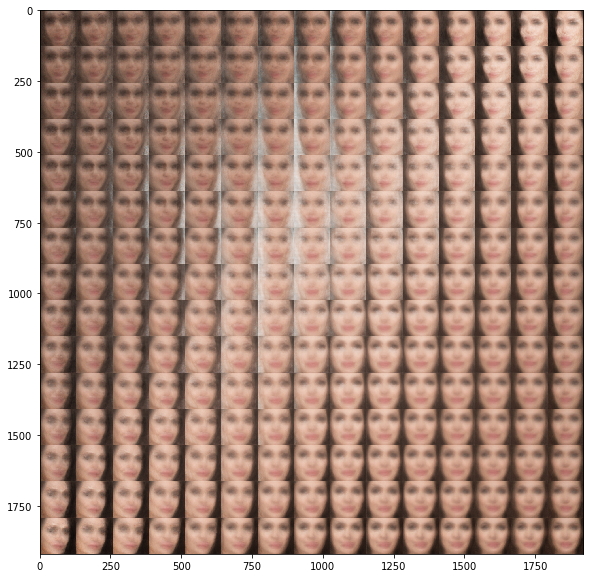

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n,3))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95,n))
grid_y = norm.ppf(np.linspace(0.05, 0.95,n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size,3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,)
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another 
as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", 
"one-ness", etc.